
# Comparação entre o algoritmo de PageRank Sequencial e sua versão paralelizada.

# IMPORTANTE
Esse Notebook foi gerado com o Google Colab.
Não testamos a execução dele localmente.
O Notebook no Colab pode ser acessado em: https://colab.research.google.com/drive/1uLXobaaVyCI-64c5dUChakw4jhSOpFUE?usp=sharing


# Introdução
O presente relatório tem por objetivo apresentar o efetivo progresso realizado pelos estudantes João Vitor Spolavore e Thiago Gonçalves da análise comparativa entre o algoritmo PageRank Sequencial e sua versão Paralela. Ainda, explicaremos como o projeto foi realizado, as decisões tomadas, as escolhas de parâmetros, os resultados até o momento e , por fim, citar as dificuldades enfrentadas ao longo do projeto.


---
# Ambiente de teste

## Máquina utilizada
Todos os experimentos realizados foram executados no Parque de Computação de Alto Desempenho (PCAD) da Universidade Federal do Rio Grande do Sul (UFRGS). Mais especificamente utilizamos o nó computacional denominado *blaise* - por questões de comodidade utilizaremos nó computacional e máquina indistintamente. As características e especificações dessa máquina estão descritas abaixo:

| Nome   | Partição | CPU                                                             | RAM         | Acelerador | Disco                  | Placa-mãe         |
|--------|----------|-----------------------------------------------------------------|-------------|------------|------------------------|-------------------|
| blaise | blaise   | 2 x Intel(R) Xeon(R) E5-2699 v4, 2.20 GHz, 88 threads, 44 cores | 256 GB DDR4 | -          | 1.8 TB SSD, 1.8 TB HDD | Supermicro X10DGQ |
|        |          |                                                                 |             |            |                        |                   |
|        |          |                                                                 |             |            |                        |                   |

*Gerador da tabela acima utilizado: https://www.tablesgenerator.com/markdown_tables*

Perceba que ela possui **dois** processadores Intel, essa informação é de grande interesse do grupo e foi fundamental para a escolha dessa máquina, uma vez que isso possibilita uma gama de experimentos que modificam, por exemplo, como as threads criadas pelo programa serão distruídas entre esses processadores.

---

# Parâmetros considerados

Antes de comentar sobre os parâmetros considerados, cabe destacar que fixamos a frequência da CPU para o máximo possível a fim de garantir que todos os testes tivessem igualdade na frêquencia utilizada. Isso foi realizado modificando o governor através do comando `cpufreq-set -g performance`.

Observando toda a gama de variáveis que podemos manipular, nós consideramos essas opções pra analisarmos em nossa pesquisa:
- **Número de Threads**
  - Objetivo do nosso estudo, é o que planejamos utilizar pra averiguar a escalabilidade do nosso programa. Escolhemos variar entre {1, 4, 12, 22, 28, 36, 44, 66, 88}. Essa sequência foi escolhida fundamentalmente para abrangir os números 22, 44 e 88, uma vez que eles representam a quantidade de threads físicas em um processador, a quantidade de threads totais (lógicas + físicas) em um processador e a quantidade total de threads da máquina ( considerando os dois processadores presentes) respectivamente.
- **Tipo de análise feita pelo Profiler**
  - Com diferentes tipos de análise, vamos poder obter mais informações sobre:
    - Onde o programa gasta mais tempo executando.
    - Eficácia da paralelização.
    - Diferença do uso e atribuição de threads dependendo da política de escolha de threads.
  - Escolhemos 3 tipos de análise: {hpc-performance, hotspots, performance-snapshot}, como já mencionamos na etapa 1.
- **Estado do Hyperthreading (ON/OFF)**
  - O Hyperthreading (ou Simultaneous MultiThreading) possibilita um processador agir como dois "cores" lógicos, executando múltiplas threads mais eficientemente.
  - Queremos saber o quanto isso pode impactar no desempenho de uma aplicação como a nossa.
  - Cabe destacar que não conseguimos efetivamente desligar o hyperthreading do nó computacional, uma vez que isso necessitaria acesso a BIOS do sistema - a qual o grupo não possui acesso. Na prática, forçamos que apenas uma thread fosse rodada por core através da modificação da variável de ambiente do *OpenMP* `OMP_PLACES`. Ademais, identificamos de maneira automática as threads físicas e lógicas da máquina e, dependendo do paramêtro passado, reduzimos a visibilidade de threads lógicas do sistema operacional através da variável de ambiente `GOMP_CPU_AFFINITY`.
- **Política de "Binding" de Threads**
  - Como citado anteriormente, a máquina escolhida possui dois processadores. Com essa informação, decidimos analisar o impacto de como a distruibuição das threads entres esses processadores impacta o resultado final. Dessa forma, através da modificação da variável de ambiente `OMP_PROC_BIND` experimentamos com as duas configurações descritas abaixo.
    - close: Vincula as threads do time a lugares próximos à thread pai. Isso é útil para quando as threads compartilham dados localmente, aproveitando a localidade de cache.
    - spread: As threads de trabalho são distribuídas em partições de processadores mais distantes da thread primária, útil para reduzir a contenção em recursos compartilhados, como caches de memória.

## Algoritmo utilizado
Por questões de facilidade e segurança, decidimos utilizar uma implementação do algoritmo PageRank já consolidada no âmbito acadêmico, que faz parte do repositório GAPBS (https://github.com/sbeamer/gapbs).

### Repositório/Escolha de Entrada
Escolhemos utilizar o Stanford Large Network Dataset Collection (SNAP), já consagrado academicamente, para nossa pesquisa.(https://snap.stanford.edu/data/index.html)

Como entrada pra nossa aplicação do PageRank precisamos de uma rede de grafos **direcionados**.

Mais especificamente, escolhemos esses grafos:
  - Friendster - 65,608,366 vértices e 1,806,067,135 arestas
  - LiveJournal - 3,997,962 vértices e 34,681,189 arestas
  - Orkut - 3,072,441 vértices e 117,185,083 arestas
  - BerkStan - 685,230 vértices e 7,600,595 arestas
  - Google - 875,713 vértices e 5,105,039 arestas
  - NotreDame - 325,729 vértices e 1,497,134 arestas
  - Stanford - 281,903 vértices e 2,312,497 arestas

Além disso, todos os resultados e códigos podem ser acessados em: https://github.com/thgdsg/perf-analysis.


In [ ]:

## Clona o repositório
%%capture
!rm -rf perf-analysis/
!git clone https://github.com/thgdsg/perf-analysis/
%cd perf-analysis
%cd stage2/


## Experimentos
A fim de centralizar todos as instâncias dos experimentos desejados e automatizar o processo de execução através de scripts, criamos um *csv* contendo a definição de todos os nossos experimentos.

Além disso, executamos cada configuração 5 vezes pra garantir a robustez dos nossos resultados e também evitar o impacto de possíveis *outliers* na nossa pesquisa.

Abaixo está um exemplo da estrutura desse arquivo.

In [ ]:
import pandas as pd

df = pd.read_csv("experiments.csv", sep=",")

print(f'Quantidade de instâncias (linhas do csv): {df.shape[0]}')
print(f'Quantidade de parâmetros (colunas do csv): {df.shape[1]}')

print("Exemplo de 5 instâncias desse csv:")
df.sample(n=5)


Quantidade de instâncias (linhas do csv): 756
Quantidade de parâmetros (colunas do csv): 9
Exemplo de 5 instâncias desse csv:


,GRAPH_NAME,GRAPH_URL,THREADS,MAX_ITERS,TOLERANCE,ANALYSIS_TYPE,DISABLE_HYPERTHREADING,THREAD_BIND_POLICY,LOGS_GAPBS
506,web-NotreDame,https://snap.stanford.edu/data/web-NotreDame.t...,22,500,0.000001,hotspots,True,close,True
563,web-Stanford,https://snap.stanford.edu/data/web-Stanford.tx...,22,500,0.000001,hpc-performance,False,close,True
723,com-LiveJournal,https://snap.stanford.edu/data/bigdata/communi...,22,500,0.000001,hotspots,False,close,True
664,com-Friendster,https://snap.stanford.edu/data/bigdata/communi...,12,500,0.000001,hpc-performance,True,close,True
209,web-Stanford,https://snap.stanford.edu/data/web-Stanford.tx...,66,500,0.000001,hpc-performance,False,spread,True


### Scripts e automações
Descrevemos abaixo de maneira sucinta todos os scripts utilizados para automatizar tanto o processo de execução dos testes quanto o processo de análise e manipulação de arquivos gerados. Ainda, vale lembrar que o código fonte de todas as automações citadas estão disponível no repositório do github:  [https://github.com/thgdsg/perf-analysis](https://github.com/thgdsg/perf-analysis)

- **perf_analysis_pr.sh** (orquestração local)
  - Prepara o ambiente (clona/compila GAPBS se necessário).
  - Carrega Intel VTune e coloca CPUs em modo performance.
  - Gera comandos com src/build_commad.py e executa todos via src/commands.sh.
  - Limpa results/ antes de rodar.
- **run.slurm** (execução em cluster SLURM)
  - Clona o repositório em SCRATCH e configura governors para todos os cores.
  - Chama ./perf_analysis_pr.sh.
  - Copia results/ de volta para HOME e roda src/unify_all_results.py ao final.
- **src/build_commad.py** (geração da matriz de execuções)
  - Lê experiments.csv e monta chamadas a ./src/executa_bench.sh.
  - Replica cada configuração em múltiplos runs.
  - Escreve a sequência em src/commands.sh (encadeado com &&).
- **src/commands.sh** (execução das variações)
  - Script gerado automaticamente com todas as combinações (grafos, threads, análise, HT, afinidade).
  - Consumido por perf_analysis_pr.sh.
- **src/unify_all_results.py** (pós-processamento)
  - Copia experiments.csv para unified_results.csv e adiciona colunas.
  - Varre results/**/report.csv, extrai Elapsed Time e calcula média por configuração.
  - Define tempo sequencial (1 thread) e calcula SPEEDUP e PARALLEL_EFFICIENCY.

Fluxo resumido
1) Preparação do ambiente → 2) Geração de comandos a partir de experiments.csv →
3) Execução sistemática → 4) Coleta em results/ → 5) Unificação em unified_results.csv.

- Entrada: experiments.csv.
- Saídas: diretório results/ e unified_results.csv consolidado.
- Boas práticas embutidas
  - Reprodutibilidade via CSV;
  - limpeza de results/;
  - desempenho da CPU consistente utilizando governor DVFS performance;
  - múltiplos runs por configuração.

### Dificuldades
- O VTune gera **muitos** dados, e a grande maioria não eram de interesse do grupo.
- Falta de disponibilidade ocasional da máquina. ( Obrigado bmmoreira! )
- Conseguir deixar executando sem o Hyperthreading. Demoramos pra descobrir que não é possível utilizar políticas e variáveis no OpenMP pra desabilitar o Hyperthreading.
- Vtune gerando arquivos de saída mal formatados e grandes.
- Não estávamos acostumados a fazer pesquisa dessa forma, sendo bem novo utilizar notebooks pra gerar gráficos e fazer anotações em arquivos MarkDown e Notebooks.

## Análise dos Resultados

Considerando que o Intel VTune Profiler nos mostra vários dados pra analizar, decidimos utilizar o mais básico pra essa etapa de demonstração de progresso: o **speedup da aplicação**.

Ao paralelizarmos uma aplicação, nós esperamos que ela ganhe desempenho proporcionalmente ao número de threads que estão rodando ela. Porém, isso quase nunca é o caso.

O ganho de desempenho pode ser reduzido por diversos motivos quando aumentamos o número de threads de execução, e pretendemos nos aprofundar mais nesses possíveis motivos futuramente na nossa parte final do trabalho.

### Juntando os dados

Assim, com nosso arquivo csv de experimentos que foram rodados, iremos juntar os experimentos com os resultados obtidos colocando pra executar na máquina blaise.

Mas primeiro, vamos declarar algumas funções pra fazer essa junção e cálculo de tempo/speedup.

In [ ]:
import pandas as pd

def setSequencialTime(df, dic_key):
    csv_values = dic_key.split("_")
    grafo = csv_values[0]
    analise = csv_values[1]
    ht = csv_values[3] == 'True'
    bind = csv_values[4]

    filtro = (df["GRAPH_NAME"] == grafo) & (df["ANALYSIS_TYPE"] == analise) & (df["DISABLE_HYPERTHREADING"] == ht) & (df["THREAD_BIND_POLICY"] == bind)
    df_sequencial = df[filtro & (df["THREADS"] == 1)]

    # O tempo sequencial é o ELAPSED_TIME da configuração com 1 thread
    tempo_sequencial = df_sequencial["ELAPSED_TIME"].values[0]

    # Atualiza SEQUENTIAL_TIME pra todas as configurações da combinação (grafo, analise, ht, bind)
    df.loc[filtro, "SEQUENTIAL_TIME"] = tempo_sequencial

In [ ]:
import pandas as pd

def add_tempo_resultados(df, dic_key, tempo, contador_runs):
    csv_values = dic_key.split("_")
    grafo = csv_values[0]
    analise = csv_values[1]
    threads = int(csv_values[2])
    ht = csv_values[3] == 'True'
    bind = csv_values[4]

    filtro = (df["GRAPH_NAME"] == grafo) & (df["ANALYSIS_TYPE"] == analise)  & (df["THREADS"] == threads) & (df["THREAD_BIND_POLICY"] == bind) & (df["DISABLE_HYPERTHREADING"] == ht)

    tempo_atual = df.loc[filtro, "ELAPSED_TIME"].values[0]
    if tempo_atual == 0.0:
        df.loc[filtro, "ELAPSED_TIME"] = float(tempo)
    else:
        # Calcula média: (soma_anterior + novo_valor) / total_runs
        soma_anterior = tempo_atual * (contador_runs - 1)
        nova_soma = soma_anterior + float(tempo)
        nova_media = nova_soma / contador_runs
        df.loc[filtro, "ELAPSED_TIME"] = nova_media

In [ ]:
import pandas as pd

def calcular_speedup_parallel_efficiency(df, dic_key):
    csv_values = dic_key.split("_")
    threads = int(csv_values[2])
    grafo = csv_values[0]
    analise = csv_values[1]
    ht = csv_values[3] == 'True'
    bind = csv_values[4]
    filtro = (df["GRAPH_NAME"] == grafo) & (df["ANALYSIS_TYPE"] == analise)  & (df["THREADS"] == threads) & (df["THREAD_BIND_POLICY"] == bind) & (df["DISABLE_HYPERTHREADING"] == ht)

    sequential_time = df.loc[filtro, "SEQUENTIAL_TIME"].values[0]
    elapsed_time = df.loc[filtro, "ELAPSED_TIME"].values[0]
    speed_up = sequential_time / elapsed_time
    parallel_efficiency = sequential_time / (threads * elapsed_time)

    df.loc[filtro, "SPEEDUP"] = speed_up
    df.loc[filtro, "PARALLEL_EFFICIENCY"] = parallel_efficiency

Agora juntamos os experimentos com seus resultados, pegando o nosso objeto de estudo no results.csv de cada execução

In [ ]:
import subprocess
import time
import pandas as pd

t0 = time.time()
# Copia o arquivo experiments.csv para unified_results.csv
subprocess.run(["cp", "experiments.csv", "unified_results.csv"])
df_unified = pd.read_csv("unified_results.csv", sep=",")
# Adiciona as colunas que conterão nossos resultados
df_unified["ELAPSED_TIME"] = float(0.0)
df_unified["SPEEDUP"] = float(0.0)
df_unified["PARALLEL_EFFICIENCY"] = float(0.0)
df_unified["SEQUENTIAL_TIME"] = float(0.0)

# Pega todos os arquivos report.csv
all_csv = subprocess.run([
    "find",
    ".",
    "-regex",
    ".*/results/.*/run-.*/report.csv"
], capture_output=True, text=True, check=True)

lista_arquivos = all_csv.stdout.strip().split('\n')

# 3780
print(f'Quantidade de arquivos de resultados: {len(lista_arquivos)}')

# Contar runs por configuração
contador_runs = {}

for arquivo in lista_arquivos:
    arquivo = arquivo[2::]
    arquivo_dir = arquivo.split("/")[1::]
    grafo = arquivo_dir[0]
    analise = arquivo_dir[1]
    threads = int(arquivo_dir[2].split("-")[1])
    ht_str = arquivo_dir[3].split("-")[1]
    ht = ht_str == 'true'
    bind = arquivo_dir[4].split("-")[1]
    dic_key = f'{grafo}_{analise}_{threads}_{ht}_{bind}'

    # Contar este run
    if dic_key not in contador_runs:
        contador_runs[dic_key] = 0
    contador_runs[dic_key] += 1

    df = pd.read_csv(arquivo, sep='\t', engine='python', header=0, on_bad_lines="skip")

    if(analise == 'hpc-performance'):
        tempo = df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0]
    elif(analise == 'hotspots'):
        tempo = df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0]
    elif(analise == 'performance-snapshot'):
        tempo = df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0]

    add_tempo_resultados(df_unified, dic_key, tempo, contador_runs[dic_key])

# Calcular sequential time após processar todos os elapsed times
for dic_key in contador_runs:
    csv_values = dic_key.split("_")
    threads = int(csv_values[2])
    if threads == 1:
        setSequencialTime(df_unified, dic_key)

# Calcular speedup e parallel efficiency
for dic_key in contador_runs:
    calcular_speedup_parallel_efficiency(df_unified, dic_key)

# Salvar o DataFrame atualizado para o arquivo CSV
df_unified.to_csv("unified_results.csv", sep=",", index=False)

t1 = time.time()
print(f"Tempo de execução: {t1 - t0} segundos")

Quantidade de arquivos de resultados: 3780
Tempo de execução: 14.482853651046753 segundos


Printando as colunas dos resultados, pra mostrar melhor os objetos de interesse da nossa pesquisa.

Também mostrando 5 linhas aleatórias do nosso DataFrame com os resultados e experimentos.

In [ ]:
import pandas as pd

print("Colunas do DataFrame unified_results:")
print(df_unified.columns)

print("\nAmostra de 5 linhas do DataFrame unified_results:")
display(df_unified.sample(n=5))

Colunas do DataFrame unified_results:
Index(['GRAPH_NAME', 'GRAPH_URL', 'THREADS', 'MAX_ITERS', 'TOLERANCE',
       'ANALYSIS_TYPE', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY',
       'LOGS_GAPBS', 'ELAPSED_TIME', 'SPEEDUP', 'PARALLEL_EFFICIENCY',
       'SEQUENTIAL_TIME'],
      dtype='object')

Amostra de 5 linhas do DataFrame unified_results:


,GRAPH_NAME,GRAPH_URL,THREADS,MAX_ITERS,TOLERANCE,ANALYSIS_TYPE,DISABLE_HYPERTHREADING,THREAD_BIND_POLICY,LOGS_GAPBS,ELAPSED_TIME,SPEEDUP,PARALLEL_EFFICIENCY,SEQUENTIAL_TIME
232,com-Orkut,https://snap.stanford.edu/data/bigdata/communi...,12,500,0.000001,hpc-performance,True,spread,True,3.399444,1.755415,0.146285,5.967435
220,com-Orkut,https://snap.stanford.edu/data/bigdata/communi...,1,500,0.000001,hpc-performance,True,spread,True,5.967435,1.000000,1.000000,5.967435
511,web-NotreDame,https://snap.stanford.edu/data/web-NotreDame.t...,28,500,0.000001,performance-snapshot,False,close,True,0.493391,2.706346,0.096655,1.335288
273,com-Friendster,https://snap.stanford.edu/data/bigdata/communi...,1,500,0.000001,hotspots,False,spread,True,26.270792,1.000000,1.000000,26.270792
577,web-Stanford,https://snap.stanford.edu/data/web-Stanford.tx...,44,500,0.000001,performance-snapshot,False,close,True,0.797133,4.275570,0.097172,3.408199


Dando uma olhada nos tempos médios de execução pra cada grafo, separados por número de threads.

Olhando preliminarmente, parece que a eficiência melhora conforme aumenta o número de threads, exceto de 66 pra 88 threads.

In [ ]:
import pandas as pd

# Carrega os resultados unificados
df_unified = pd.read_csv("unified_results.csv", sep=",")

# Calcula o tempo médio de execução por grafo, tipo de análise e número de threads
average_time_by_graph_analysis_threads = df_unified.groupby(["GRAPH_NAME", "ANALYSIS_TYPE", "THREADS"])["ELAPSED_TIME"].mean().reset_index()

# Pivota a tabela para ter uma coluna para cada quantidade de threads
pivot_table = average_time_by_graph_analysis_threads.pivot_table(
    index=["GRAPH_NAME", "ANALYSIS_TYPE"],
    columns="THREADS",
    values="ELAPSED_TIME"
)

# Exibe a tabela
print("Tempo Médio de Execução por Grafo, Tipo de Análise e Número de Threads:")
display(pivot_table)

Tempo Médio de Execução por Grafo, Tipo de Análise e Número de Threads:


THREADS                                      1          4         12  \
GRAPH_NAME      ANALYSIS_TYPE                                          
com-Friendster  hotspots              31.572248  14.409384  7.420061   
                hpc-performance       30.597228  14.158959  7.566079   
                performance-snapshot  29.882770  14.371425  7.391768   
com-LiveJournal hotspots               1.145601   0.873250  0.568871   
                hpc-performance        1.065902   0.761413  0.506477   
                performance-snapshot   1.019866   0.773590  0.459835   
com-Orkut       hotspots               6.227418   4.719341  3.532510   
                hpc-performance        6.184094   4.634889  3.385469   
                performance-snapshot   6.134138   4.623114  3.384429   
web-BerkStan    hotspots               6.496600   2.858123  2.009930   
                hpc-performance        6.504278   2.777164  1.970251   
                performance-snapshot   6.417137   2.719893  1.878581   
web-Google      hotspots               8.574722   3.635511  1.992873   
                hpc-performance        8.534743   3.615123  1.955658   
                performance-snapshot   8.352678   3.551624  1.876932   
web-NotreDame   hotspots               1.425846   0.734581  0.611220   
                hpc-performance        1.354404   0.671312  0.570364   
                performance-snapshot   1.339620   0.643589  0.504171   
web-Stanford    hotspots               3.508838   1.681844  1.049184   
                hpc-performance        3.443769   1.588889  1.002274   
                performance-snapshot   3.393861   1.564340  0.948776   

THREADS                                     22        28        36        44  \
GRAPH_NAME      ANALYSIS_TYPE                                                  
com-Friendster  hotspots              6.403854  7.015749  7.787302  7.612774   
                hpc-performance       6.321088  6.948686  7.707334  8.013490   
                performance-snapshot  6.299217  6.988925  7.514694  7.483792   
com-LiveJournal hotspots              0.519191  0.506860  0.477419  0.478405   
                hpc-performance       0.511834  0.516261  0.546047  0.589614   
                performance-snapshot  0.405350  0.378825  0.361804  0.355137   
com-Orkut       hotspots              3.083030  2.993562  2.902121  2.844003   
                hpc-performance       3.031974  3.018918  2.927874  2.930483   
                performance-snapshot  2.918719  2.844050  2.750334  2.696680   
web-BerkStan    hotspots              1.824812  1.804970  1.703735  1.694472   
                hpc-performance       1.860855  1.858420  1.785006  1.824912   
                performance-snapshot  1.715524  1.695343  1.569064  1.579129   
web-Google      hotspots              1.603539  1.467148  1.447616  1.458352   
                hpc-performance       1.610598  1.519782  1.519248  1.560159   
                performance-snapshot  1.495703  1.371425  1.335087  1.329902   
web-NotreDame   hotspots              0.557873  0.564672  0.590112  0.579064   
                hpc-performance       0.577838  0.605225  0.647647  0.687972   
                performance-snapshot  0.460593  0.461122  0.464586  0.467689   
web-Stanford    hotspots              0.839590  0.857734  0.858841  0.873750   
                hpc-performance       0.842436  0.875945  0.913057  0.954027   
                performance-snapshot  0.728759  0.740561  0.737091  0.738581   

THREADS                                     66        88  
GRAPH_NAME      ANALYSIS_TYPE                             
com-Friendster  hotspots              7.876231  8.291894  
                hpc-performance       8.495687  8.908639  
                performance-snapshot  7.741725  8.074210  
com-LiveJournal hotspots              0.504745  0.542597  
                hpc-performance       0.711114  0.834391  
                performance-snapshot  0.369524  0.379666  
com-Orkut       hotspots      

## Gráficos dos resultados

### Comentários Gerais
- Como esperado, o hyperthreading teve uma diferença significativa, em alguns casos, no desempenho do algoritmo.
- A política de *binding* também teve impacto em alguns casos, até maior do que o grupo imaginava.
- Como o tipo de análise *performance-snapshot* é o com menor overhead (podemos ver isso nos tempos de execução acima), seria o mais relevante de ser analizado em termos de similaridade ao desempenho da aplicação.
- Em alguns grafos o Hyperthreading ligado com a política de binding "close" se manteve com desempenho pior que os outros, mas ao executar com 66 e 88 threads o desempenho melhorou.

### Casos Mais Relevantes
- Stanford, performance-snapshot, HT_OFF_CLOSE com 22 threads.
- Orkut, todos, HT_ON_CLOSE, todas combinações de threads.



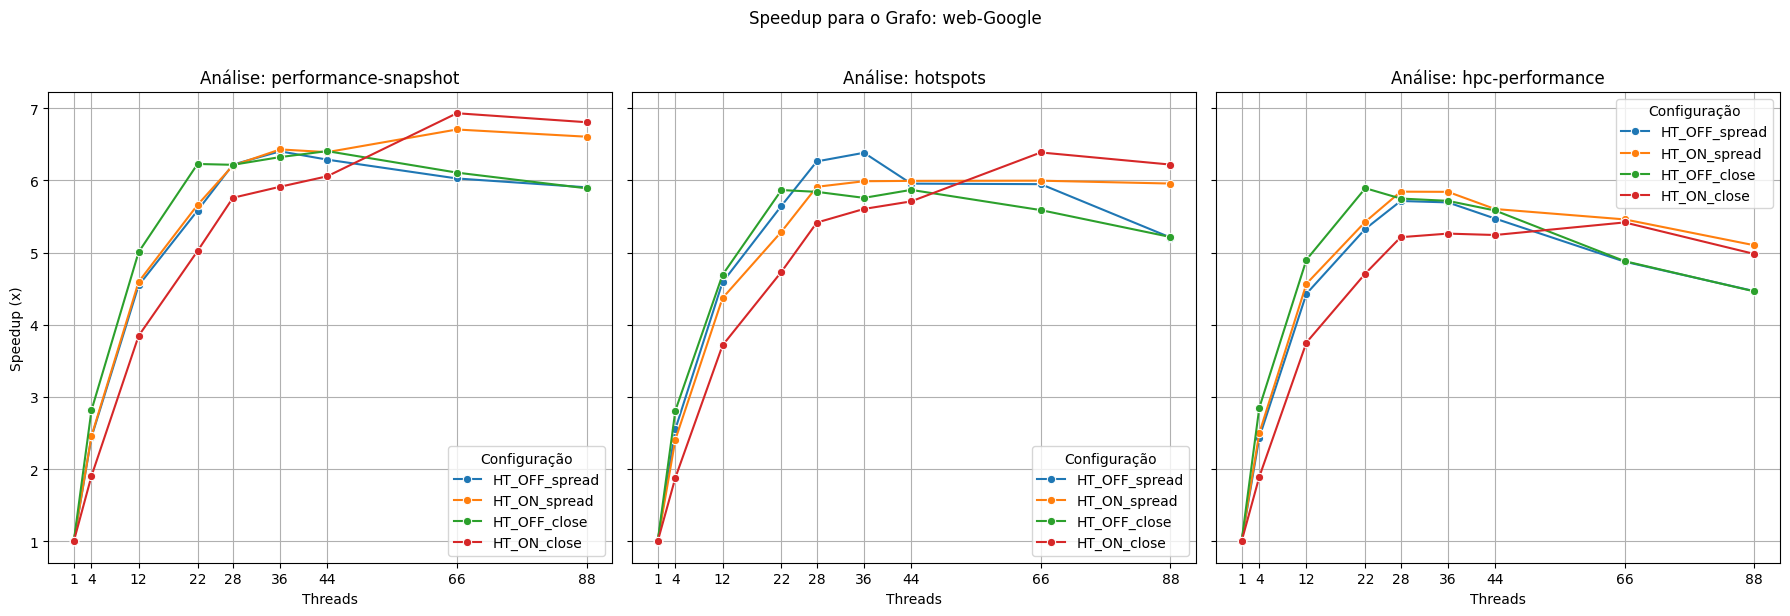

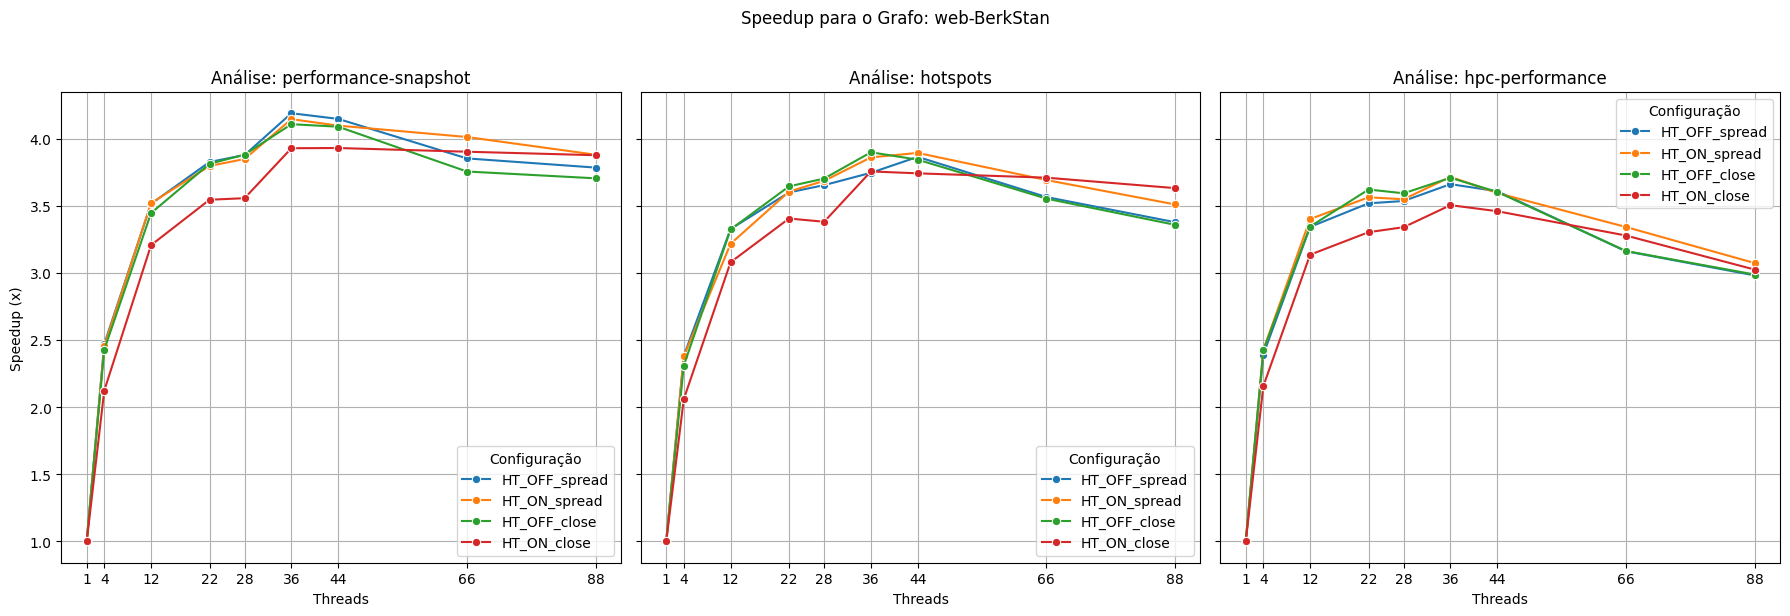

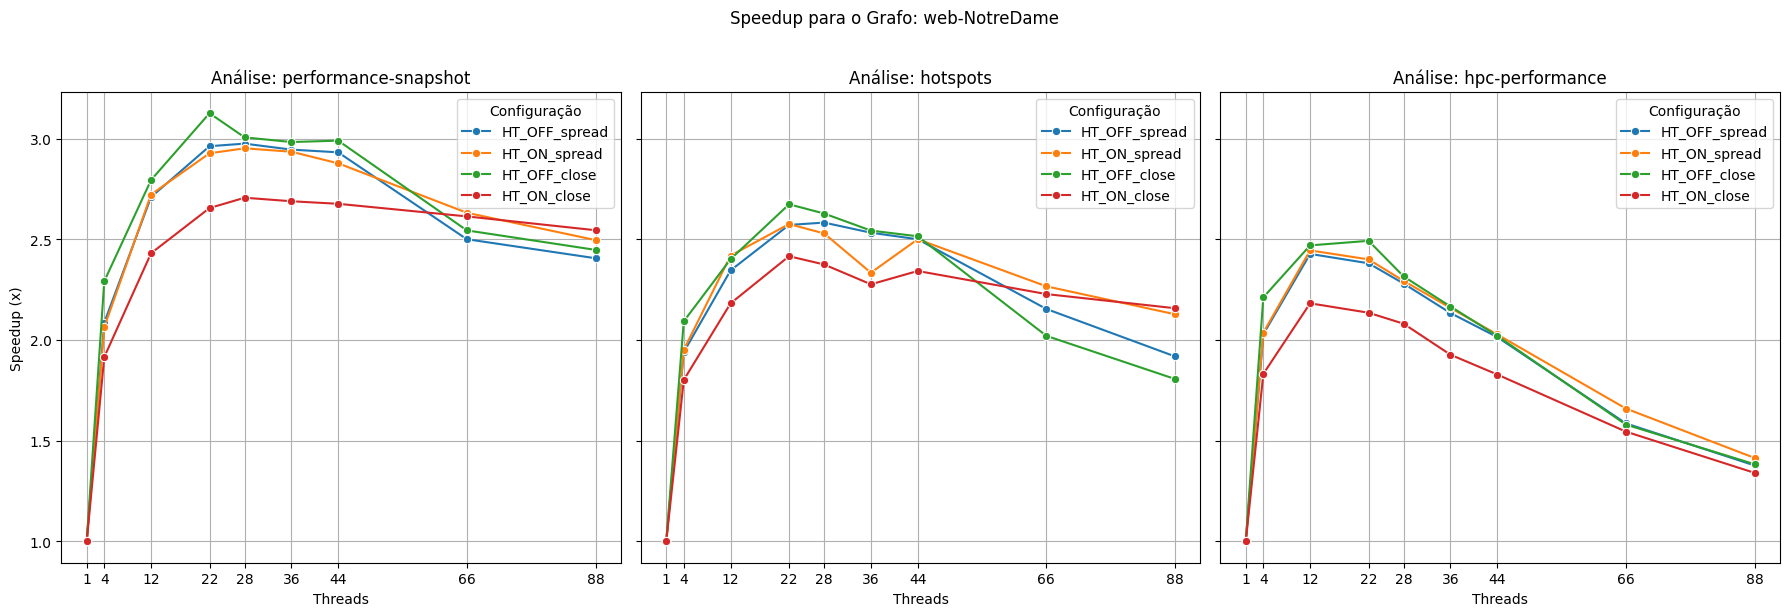

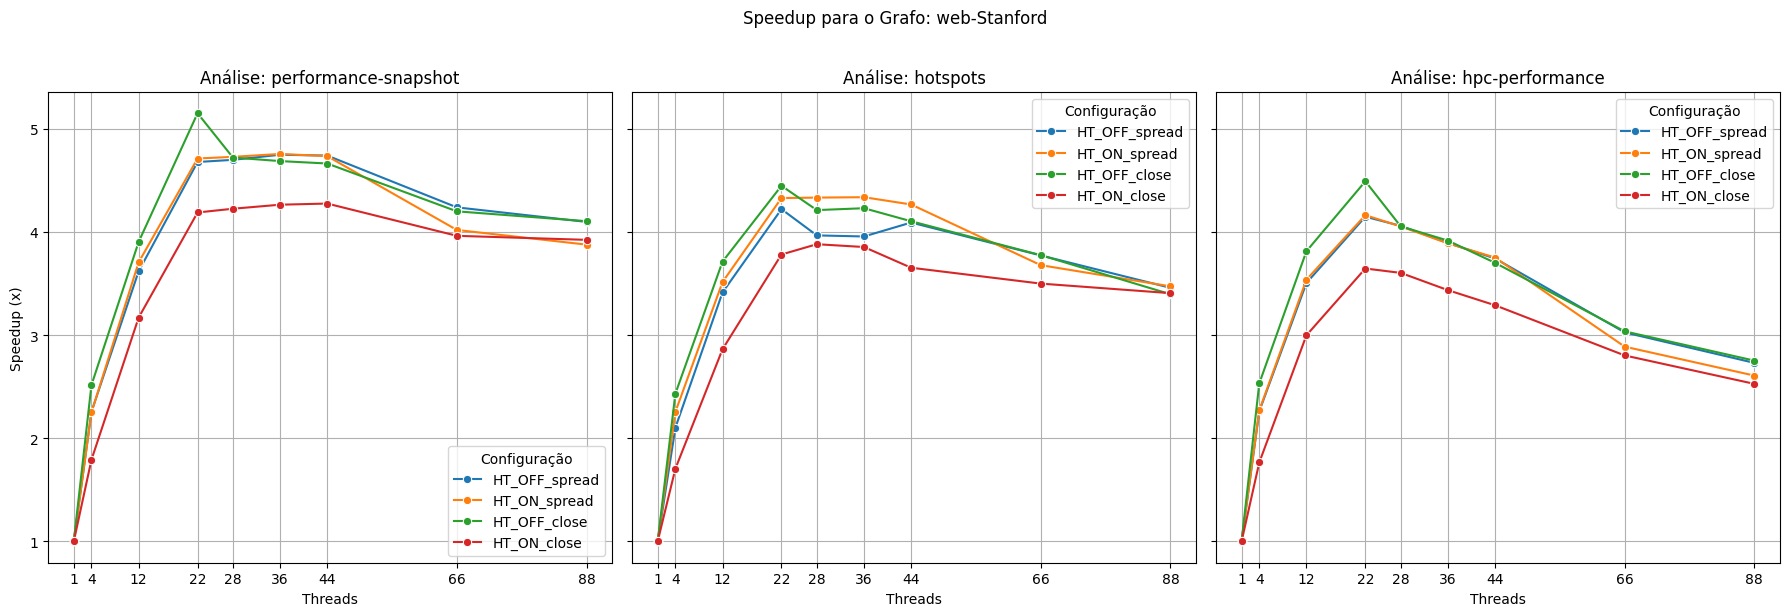

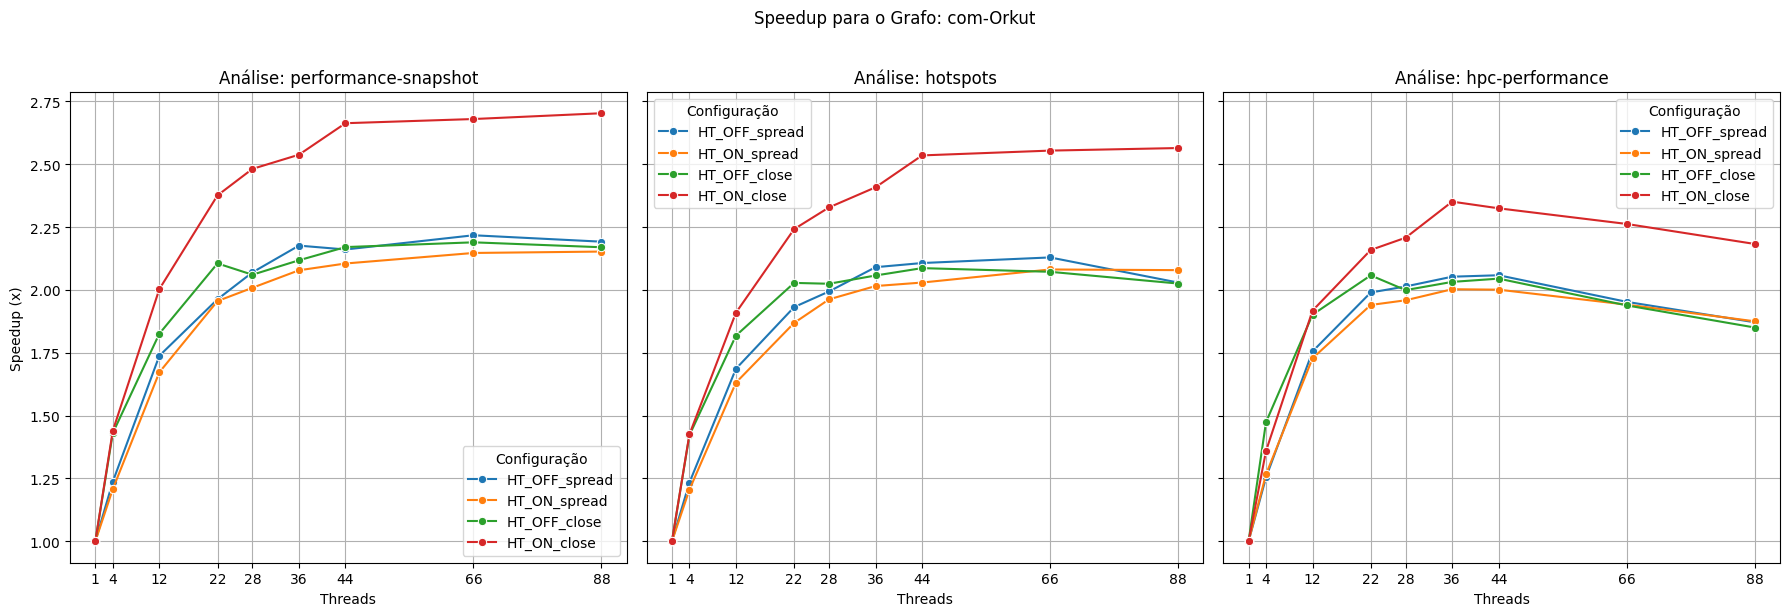

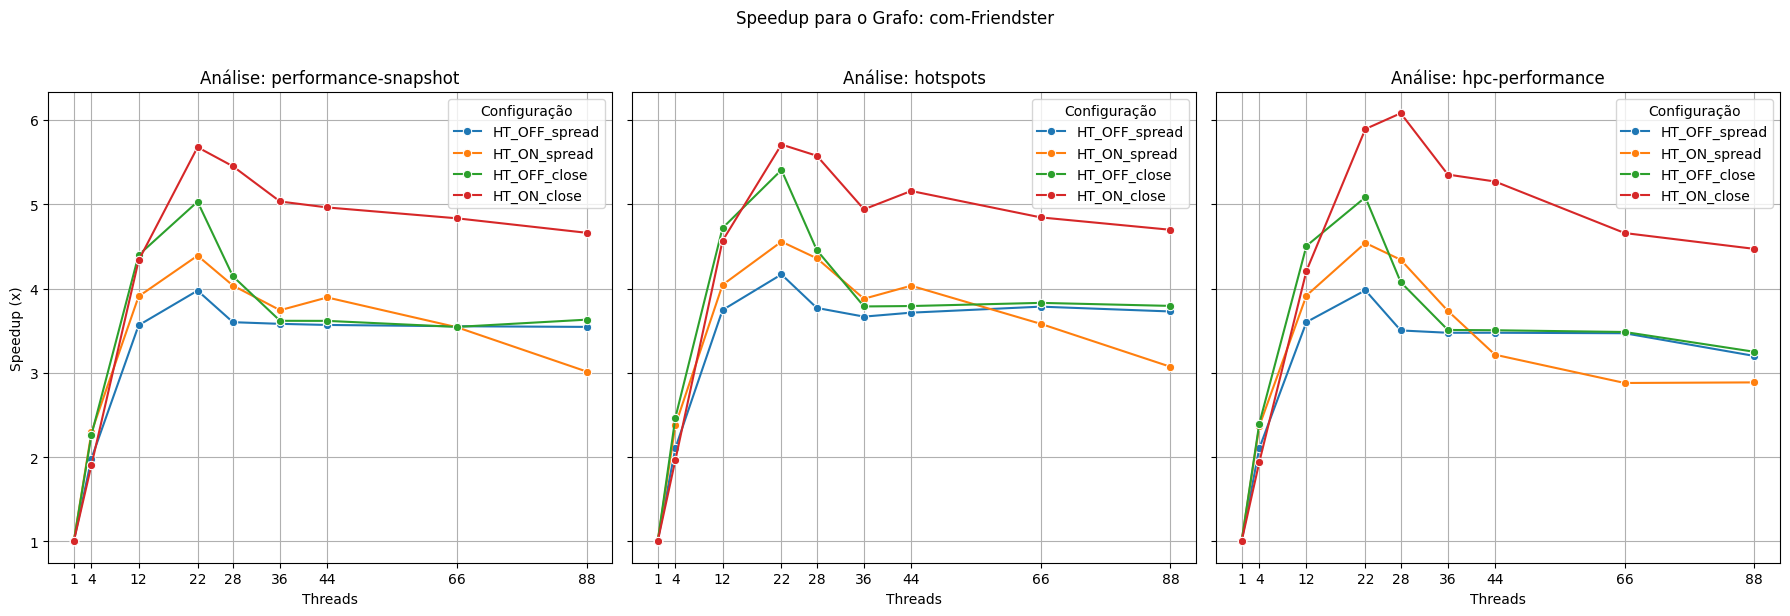

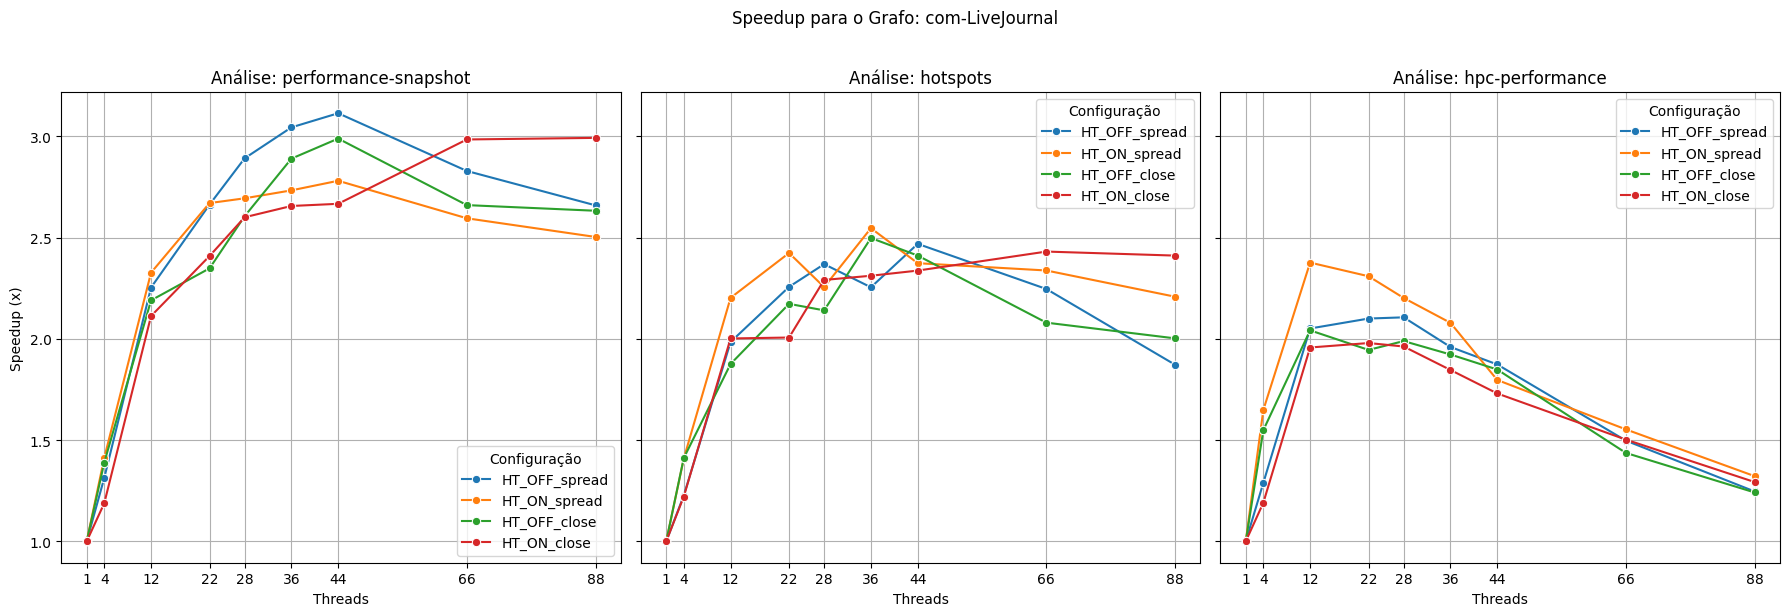

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega os resultados unificados
df_unified = pd.read_csv("unified_results.csv", sep=",")

# Obtém listas únicas de grafos e tipos de análise
grafos = df_unified["GRAPH_NAME"].unique()
tipos_analise = df_unified["ANALYSIS_TYPE"].unique()

# Determina o número de colunas para cada subplot
n_cols = len(tipos_analise)

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre cada grafo para gerar os gráficos agrupados por tipo de análise e salvar como PDF
for grafo in grafos:
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)
    fig.suptitle(f"Speedup para o Grafo: {grafo}", y=1.02) # Add a main title for the graph

    if n_cols == 1:
        axes = [axes]

    for i, analise in enumerate(tipos_analise):
        # Filtra os dados para o grafo e tipo de análise atuais
        df_filtered = df_unified[(df_unified["GRAPH_NAME"] == grafo) & (df_unified["ANALYSIS_TYPE"] == analise)].copy()

        # Cria uma coluna combinada para hyperthreading e thread binding policy para utilizar na legenda
        df_filtered["CONFIG"] = df_filtered["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if not x else "HT_OFF") + "_" + df_filtered["THREAD_BIND_POLICY"]

        # Cria o gráfico de speedup X número de threads no subplot atual
        sns.lineplot(data=df_filtered, x="THREADS", y="SPEEDUP", hue="CONFIG", marker="o", ax=axes[i])
        axes[i].set_title(f"Análise: {analise}")
        axes[i].set_xlabel("Threads")
        axes[i].set_ylabel("Speedup (x)")
        axes[i].grid(True)
        axes[i].set_xticks(df_filtered["THREADS"].unique())
        axes[i].legend(title="Configuração")

    plt.tight_layout()
    # Salva a figura como um arquivo PDF na pasta "gráficos"
    plt.savefig(os.path.join(output_dir, f"speedup_{grafo}.pdf"))
    # Mostra a figura no notebook
    plt.show()

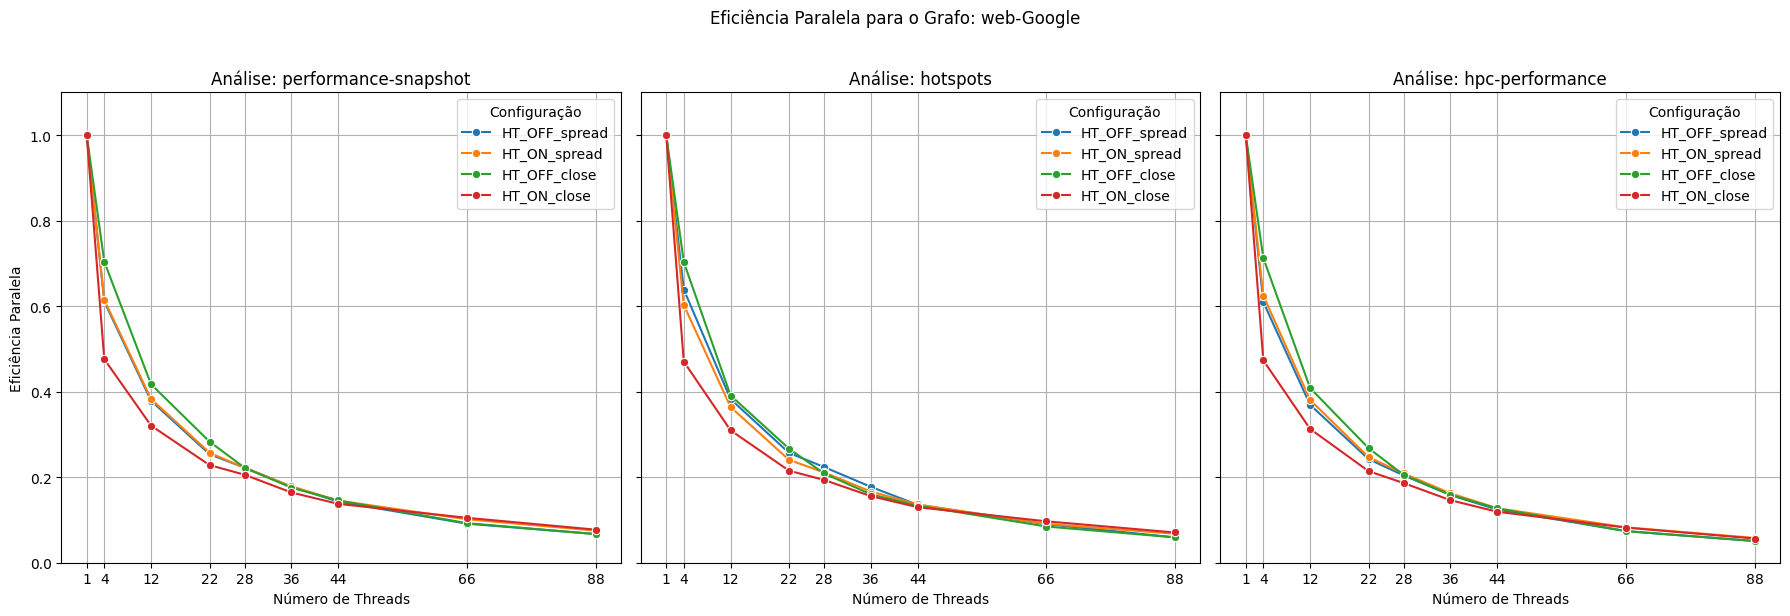

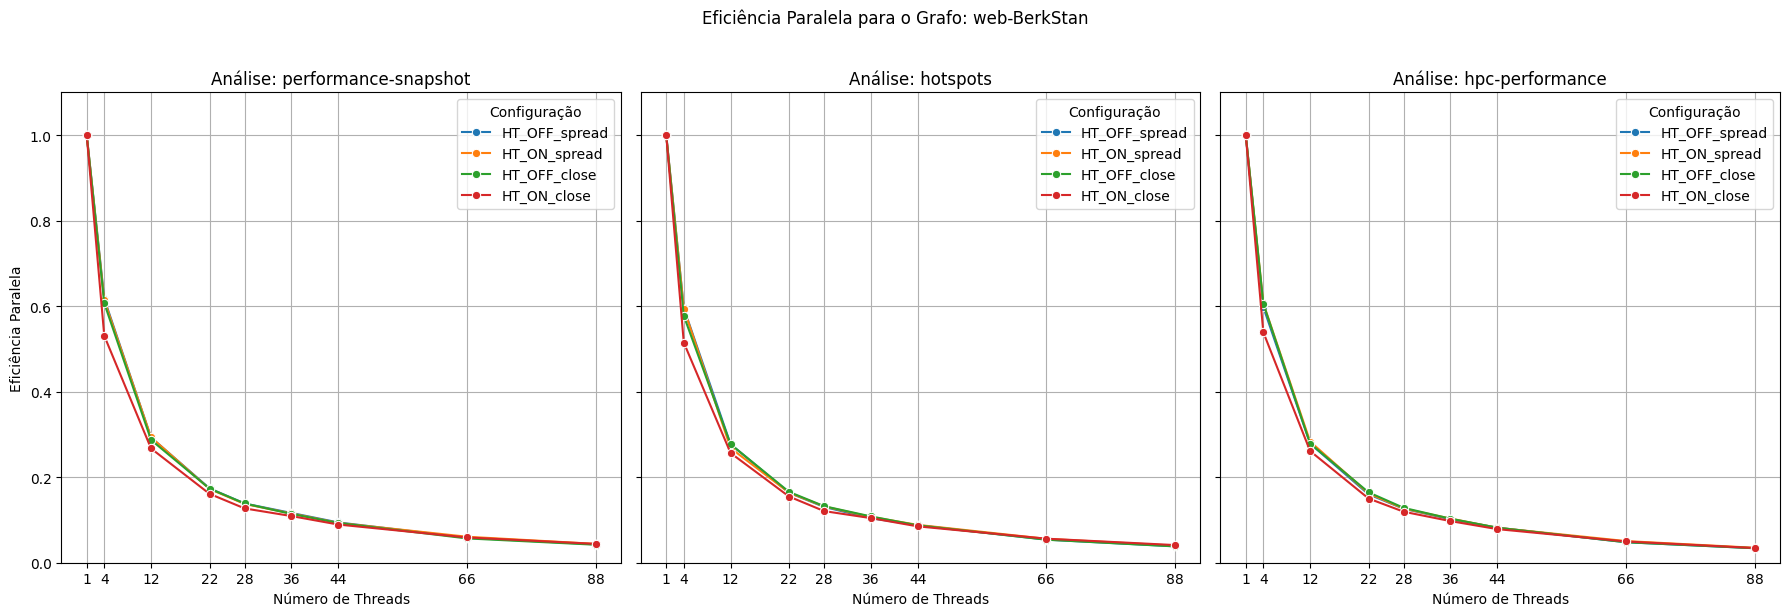

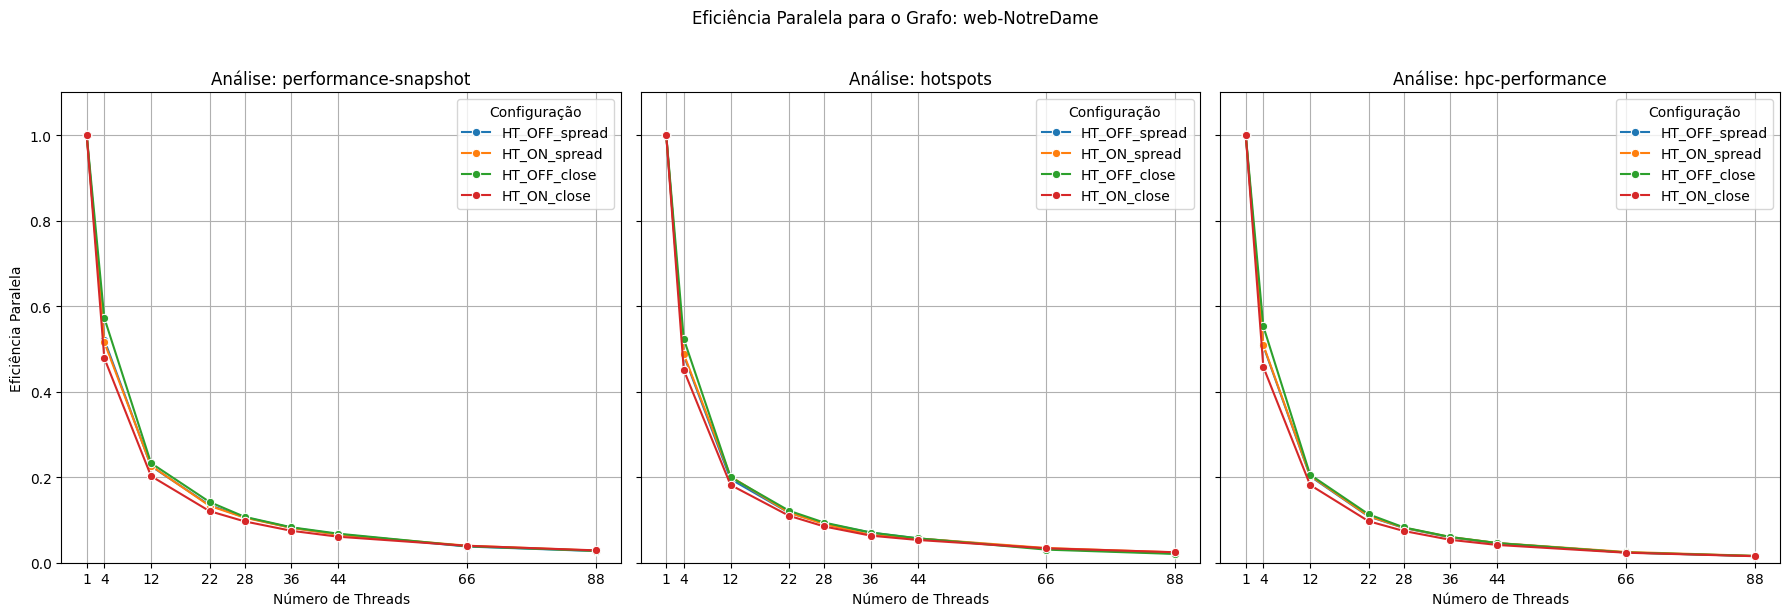

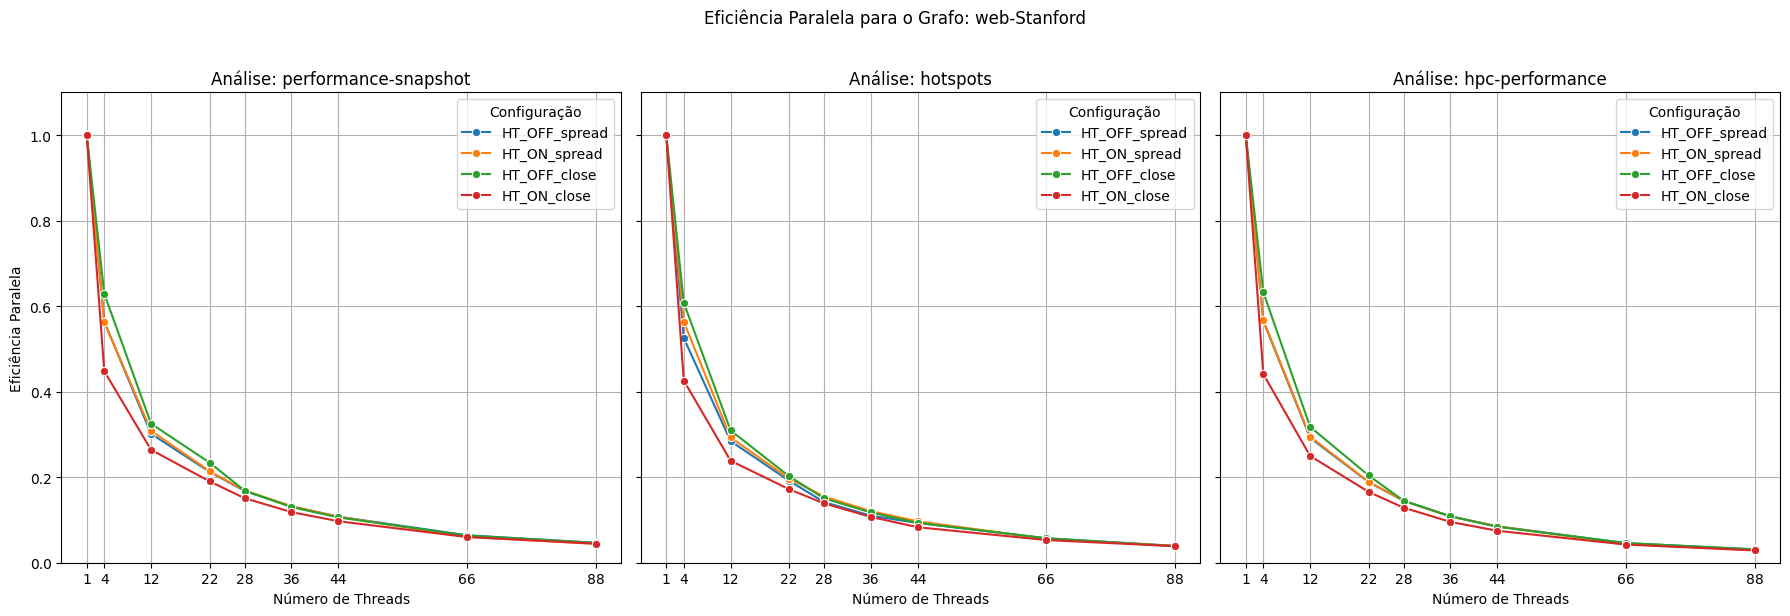

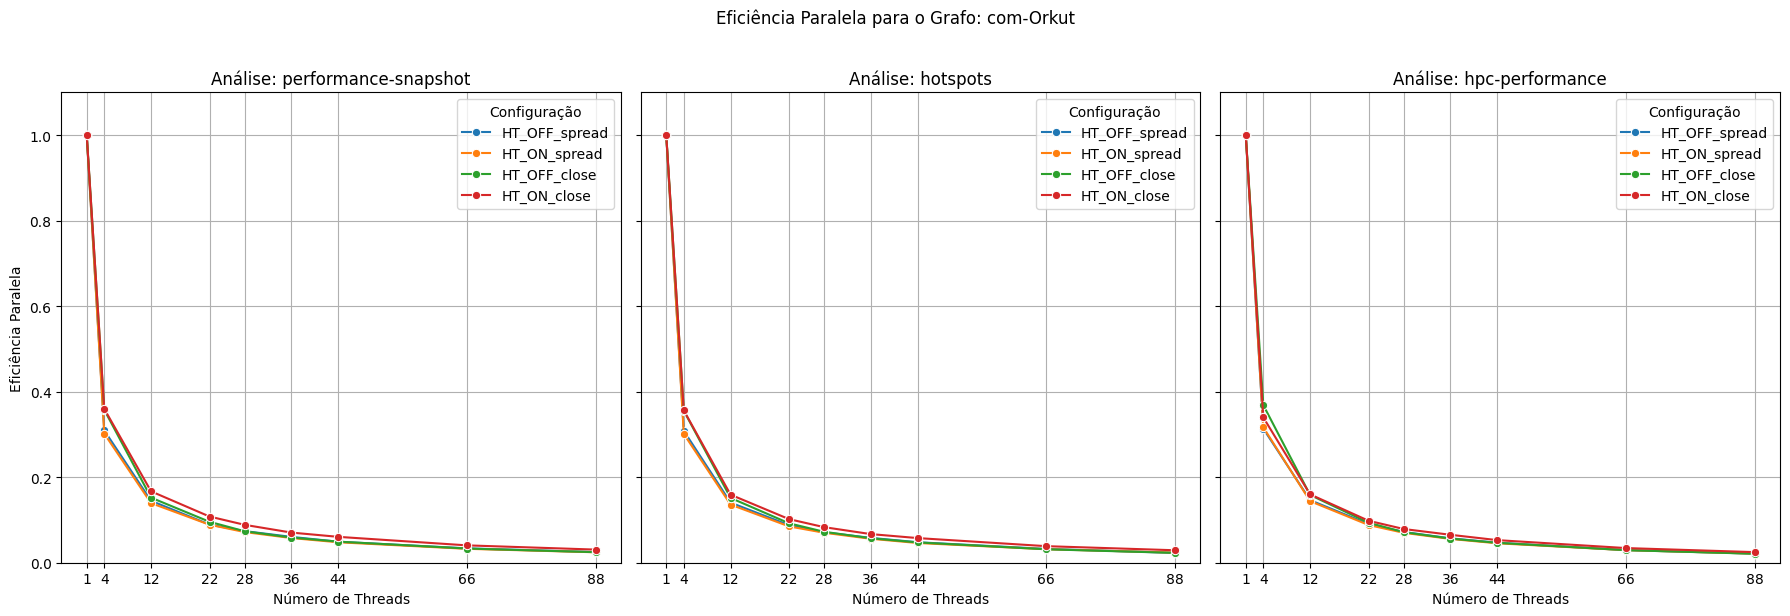

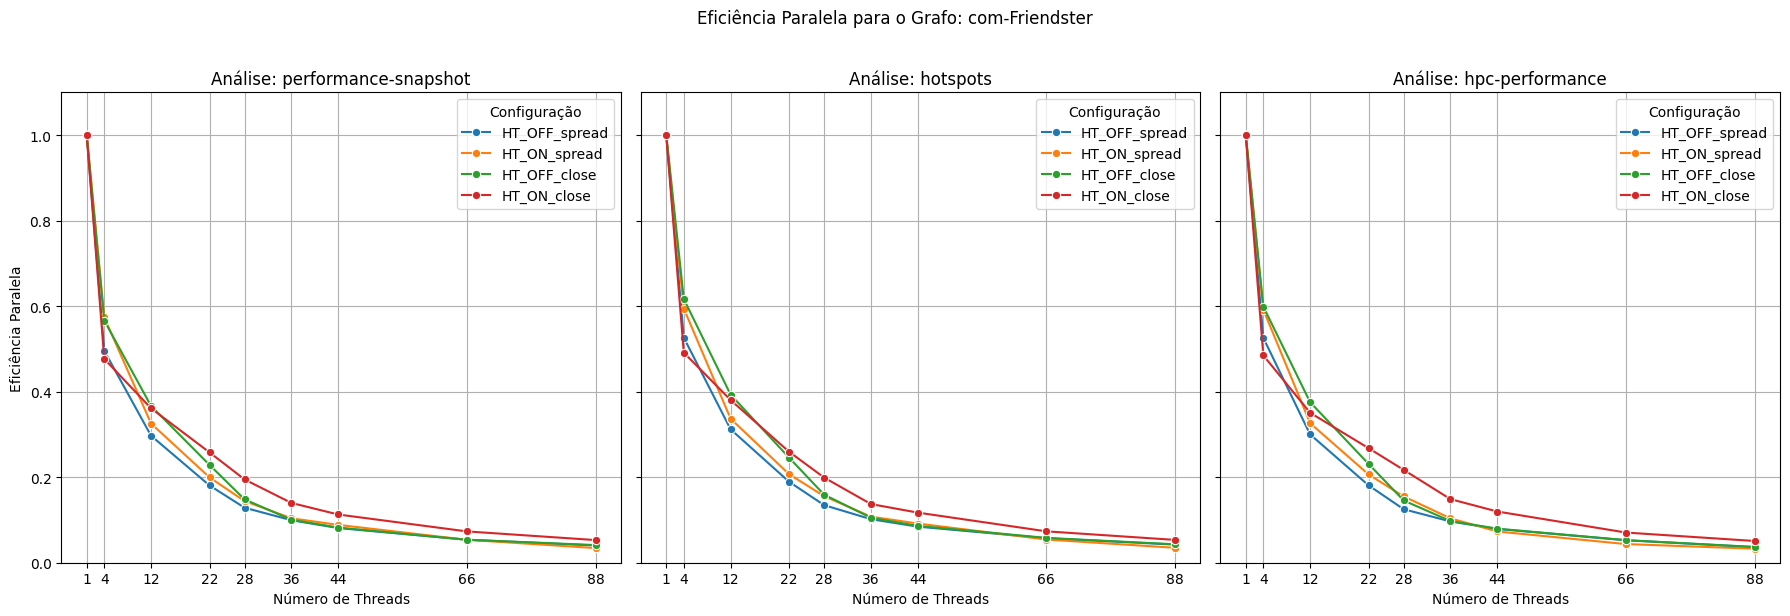

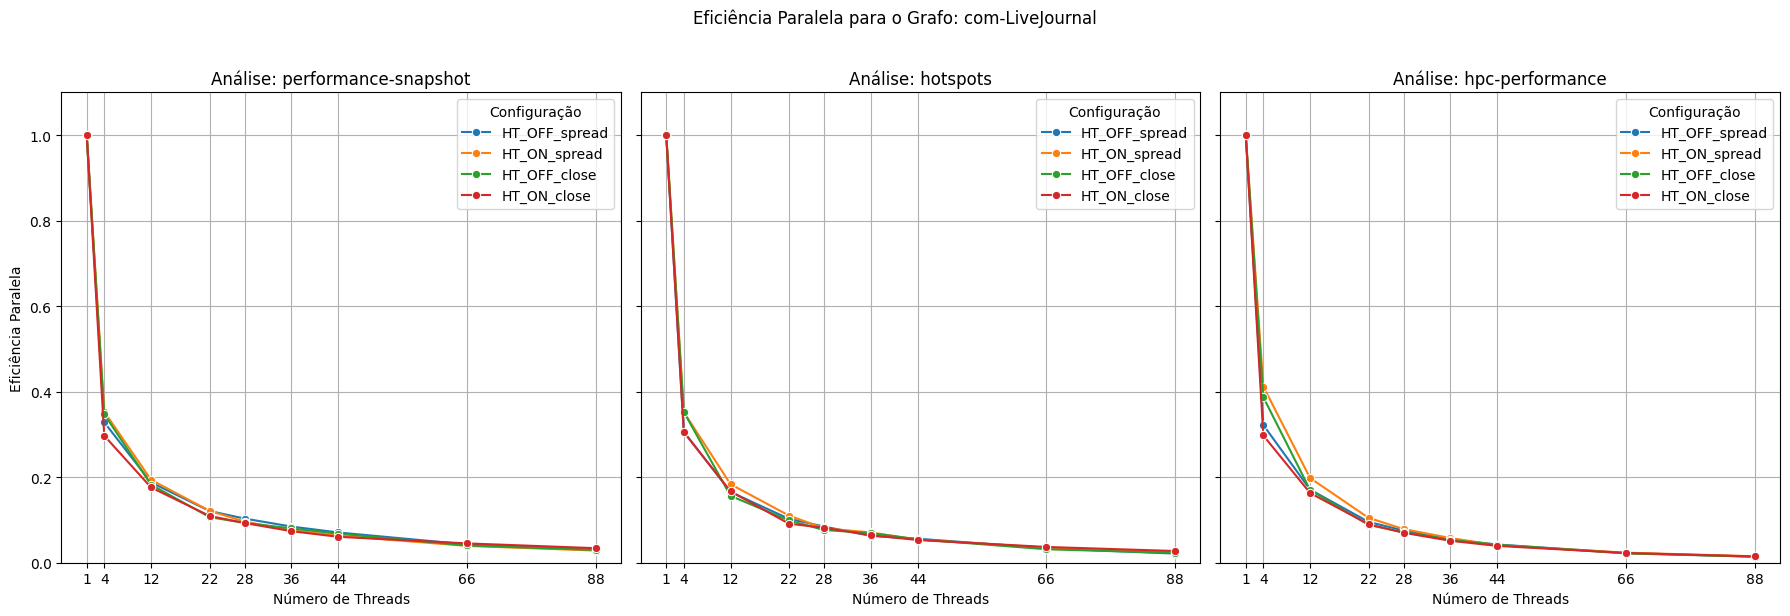

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega os resultados unificados
df_unified = pd.read_csv("unified_results.csv", sep=",")

# Obtém listas únicas de grafos e tipos de análise
grafos = df_unified["GRAPH_NAME"].unique()
tipos_analise = df_unified["ANALYSIS_TYPE"].unique()

# Determina o número de colunas pra cada subplot
n_cols = len(tipos_analise)

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre cada grafo pra gerar os gráficos agrupados por tipo de análise
for grafo in grafos:
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)
    fig.suptitle(f"Eficiência Paralela para o Grafo: {grafo}", y=1.02) # Add a main title for the graph

    if n_cols == 1:
        axes = [axes]

    for i, analise in enumerate(tipos_analise):
        # Filtra os dados pro grafo e tipo de análise atuais
        df_filtered = df_unified[(df_unified["GRAPH_NAME"] == grafo) & (df_unified["ANALYSIS_TYPE"] == analise)].copy()

        # Cria uma coluna combinada pra hyperthreading e thread binding policy pra usar na legenda
        df_filtered["CONFIG"] = df_filtered["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if not x else "HT_OFF") + "_" + df_filtered["THREAD_BIND_POLICY"]

        # Cria o gráfico de parallel efficiency X número de threads no subplot atual
        sns.lineplot(data=df_filtered, x="THREADS", y="PARALLEL_EFFICIENCY", hue="CONFIG", marker="o", ax=axes[i])
        axes[i].set_title(f"Análise: {analise}")
        axes[i].set_xlabel("Número de Threads")
        axes[i].set_ylabel("Eficiência Paralela")
        axes[i].grid(True)
        axes[i].set_xticks(df_filtered["THREADS"].unique())
        axes[i].legend(title="Configuração")
        axes[i].set_ylim(0, 1.1)

    plt.tight_layout()
    # Salva a figura como um arquivo PDF na pasta "gráficos"
    plt.savefig(os.path.join(output_dir, f"parallel_efficiency_{grafo}.pdf"))
    # Mostra a figura no notebook
    plt.show()

In [ ]:
# Encontra as melhores configurações por grafo e tipo de análise com base no maior speedup
best_configs = df_unified.loc[df_unified.groupby(['GRAPH_NAME', 'ANALYSIS_TYPE'])['SPEEDUP'].idxmax()]

# Seleciona apenas as colunas relevantes
best_configs_table = best_configs[['GRAPH_NAME', 'ANALYSIS_TYPE', 'THREADS', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY', 'SPEEDUP']]

# Mostra a tabela
print("Melhores Configurações por Grafo e Tipo de Análise (baseado no maior Speedup):")
display(best_configs_table)

Melhores Configurações por Grafo e Tipo de Análise (baseado no maior Speedup):


,GRAPH_NAME,ANALYSIS_TYPE,THREADS,DISABLE_HYPERTHREADING,THREAD_BIND_POLICY,SPEEDUP
669,com-Friendster,hotspots,22,False,close,5.708463
677,com-Friendster,hpc-performance,28,False,close,6.079737
667,com-Friendster,performance-snapshot,22,False,close,5.676505
357,com-LiveJournal,hotspots,36,False,spread,2.546151
341,com-LiveJournal,hpc-performance,12,False,spread,2.376275
360,com-LiveJournal,performance-snapshot,44,True,spread,3.113705
645,com-Orkut,hotspots,88,False,close,2.564436
629,com-Orkut,hpc-performance,36,False,close,2.351212
643,com-Orkut,performance-snapshot,88,False,close,2.702868
464,web-BerkStan,hotspots,36,True,close,3.897933
